<a href="https://colab.research.google.com/github/letianzj/QuantResearch/blob/master/notebooks/arima_garch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
from datetime import datetime, timedelta
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas_datareader as pdr

### Download Data

In [5]:
end_date = datetime.today()
# start_date = end_date + timedelta(days=-5*365)
start_date = datetime(2000, 1, 1)
spx = pdr.DataReader(name='^GSPC', data_source='yahoo', start=start_date, end=end_date)
hist_close = spx['Close']
hist_ret = hist_close / hist_close.shift(1) - 1.0     # shift 1 shifts forward one day; today has yesterday's price
# hist_ret = hist_close.pct_change(1)
hist_ret.dropna(inplace=True)
hist_ret = hist_ret * 100.0
print(hist_ret.describe())
print(f'Skew: {scipy.stats.skew(hist_ret)}, Kurtosis: {scipy.stats.kurtosis(hist_ret)}')

count    5154.000000
mean        0.022304
std         1.257819
min       -11.984055
25%        -0.478861
50%         0.056171
75%         0.573104
max        11.580037
Name: Close, dtype: float64
Skew: -0.14177550682843323, Kurtosis: 10.810032466935395


### ARIMA Model
#### Step One: Identify (p, d, q)

In [193]:
# price is known to be non-stationary; return is stationary
from statsmodels.tsa.stattools import adfuller

result = adfuller(hist_close)
print(f'ADF Statistic: {result[0]}, p-value: {result[1]}')  # null hypothesis: unit root exists; can't reject null.

result = adfuller(hist_ret)
print(f'ADF Statistic: {result[0]}, p-value: {result[1]}')   # reject null hypothesis of unit root ==> stationary          

ADF Statistic: 0.4475630646056672, p-value: 0.983189094285697
ADF Statistic: -13.677829735374534, p-value: 1.4191460530024336e-25


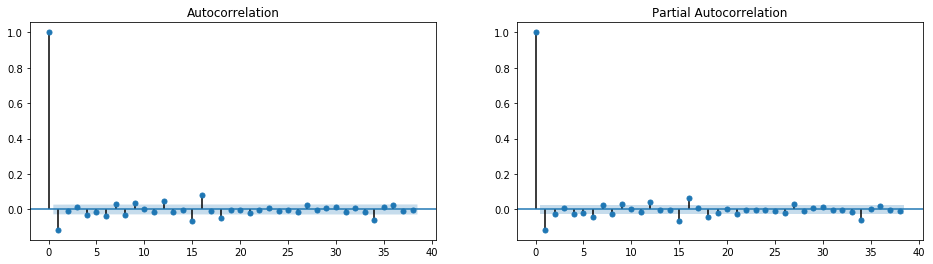

        acf      pacf
1 -0.115369 -0.115391
2 -0.011208 -0.024859
3  0.014812  0.010777
4 -0.028980 -0.026649
5 -0.014426 -0.020791


In [194]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(16, 4))
plot_acf(hist_ret, ax=axes[0])          # determines MA(q)
plot_pacf(hist_ret, ax=axes[1])         # determines AR(p)
plt.show()

act_stats = acf(hist_ret, fft=False)[1:40]                
acf_df = pd.DataFrame([act_stats]).T
acf_df.columns = ['acf']
acf_df.index += 1

pacf_stats = pacf(hist_ret)[1:40]                        
pacf_df = pd.DataFrame([pacf_stats]).T
pacf_df.columns = ['pacf']
pacf_df.index += 1

df_acf_pcaf = pd.concat([acf_df, pacf_df], axis=1)
print(df_acf_pcaf.head())

In [195]:
# acf/pacf suggests higher order of arounds 35 business days; which makes the model practically unusable.
# instead, let's constraint the order to 5 business days and use AIC to pick up the best fit
from statsmodels.tsa.arima_model import ARIMA, ARMA

hist_training = hist_ret.iloc[:-45]
hist_testing = hist_ret.iloc[-45:]

dict_aic = {}
for p in range(6):
    for q in range(6):
        try:
            model = ARIMA(hist_training, order=(p, 0, q))
            model_fit = model.fit(disp=0)
            dict_aic[(p, q)] = model_fit.aic
        except:
            pass
df_aic = pd.DataFrame.from_dict(dict_aic, orient='index', columns=['aic'])
p, q = df_aic[df_aic.aic == df_aic.aic.min()].index[0]
print(f'ARIMA order is ({p}, {0}, {q})')

d:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
d:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
d:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
d:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored

d:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
d:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
d:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
d:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored

ARIMA order is (5, 0, 5)


#### Step Two: Fit the Model

In [196]:
# train the selected model
model = ARIMA(hist_training, order=(p, 0, q))
arima_fitted = model.fit(disp=0)
arima_fitted.summary()

d:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Close   No. Observations:                 5109
Model:                     ARMA(5, 5)   Log Likelihood               -8346.209
Method:                       css-mle   S.D. of innovations              1.239
Date:                Mon, 29 Jun 2020   AIC                          16716.418
Time:                        22:28:46   BIC                          16794.883
Sample:                             0   HQIC                         16743.888
                                                                              
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0210      0.014      1.460      0.144      -0.007       0.049
ar.L1.Close    -0.8183      0.143     -5.723      0.000      -1.099      -0.538
ar.L2.Close    -0.3455      0.184     -1.879      0.060      -0.706       0.015
ar.L3.Close    -0.5809      0.171     -3.390      0.001      -0.917      -0.245
ar.L4.Close    -0.1466      0.181     -0.810      0.418      -0.501       0.208
ar.L5.Close     0.4608      0.107      4.298      0.000       0.251       0.671
ma.L1.Close     0.7046      0.139      5.063      0.000       0.432       0.977
ma.L2.Close     0.2397      0.166      1.441      0.150      -0.086       0.566
ma.L3.Close     0.5425      0.152      3.558      0.000       0.244       0.841
ma.L4.Close     0.0509      0.166      0.306      0.760      -0.275       0.377
ma.L5.Close    -0.5192      0.097     -5.371      0.000      -0.709      -0.330
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.9553           -0.4072j            1.0384           -0.4359
AR.2           -0.9553           +0.4072j            1.0384            0.4359
AR.3            0.2217           -1.0384j            1.0618           -0.2165
AR.4            0.2217           +1.0384j            1.0618            0.2165
AR.5            1.7853           -0.0000j            1.7853           -0.0000
MA.1           -0.9727           -0.4043j            1.0533           -0.4373
MA.2           -0.9727           +0.4043j            1.0533            0.4373
MA.3            0.2288           -1.0210j            1.0463           -0.2149
MA.4            0.2288           +1.0210j            1.0463            0.2149
MA.5            1.5857           -0.0000j            1.5857           -0.0000
-----------------------------------------------------------------------------
"""

#### Step Three: Residual Analysis

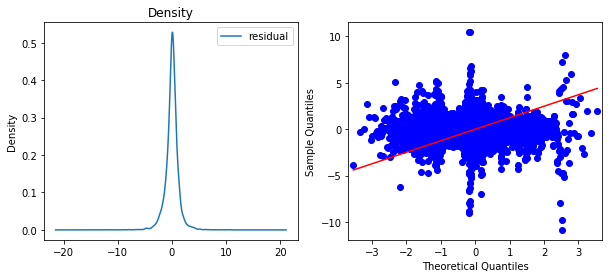

Statistics=993.676, p=0.000
Statistics=0.895, p=0.000


In [198]:
# unfortunately it doesn't look like Gaussian;
# which is somewhat expected, as acf/pacf graph has lags up to 2month ago.
residuals = pd.DataFrame(arima_fitted.resid, columns=['residual'])
fig, ax = plt.subplots(1,2, figsize=(10, 4))
# residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[0])
sm.qqplot(residuals, line='s', ax=ax[1])
plt.show()

# normality test
from scipy.stats import shapiro, normaltest
stat, p = normaltest(residuals)
print(f'Statistics={stat[0]:.3f}, p={p[0]:.3f}')       # H0: Gaussian
stat, p = shapiro(residuals)
print(f'Statistics={stat:.3f}, p={p:.3f}')       # H0: Gaussian

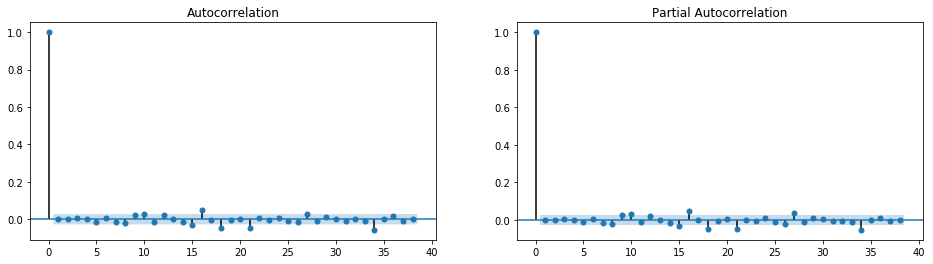

In [205]:
# Because we limit the lag orders; there still has remaining autocorrelation.
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
plot_acf(residuals, ax=axes[0])
plot_pacf(residuals, ax=axes[1])
plt.show()

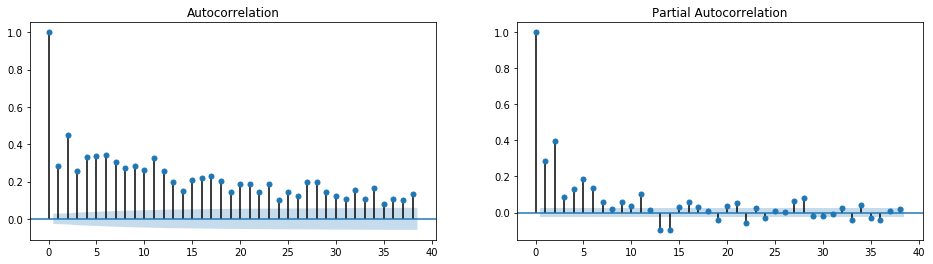

In [199]:
# In addition, There exists autocorrelation in squared residuals, suggesting GARCH
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
plot_acf(residuals**2, ax=axes[0])
plot_pacf(residuals**2, ax=axes[1])
plt.show()

#### Step Four: Forecast

In [206]:
# The fit is on return. Errors are accumulated by cumprod
return_predicted = arima_fitted.predict()
price_predicted = hist_close[0]*np.cumprod(1+return_predicted/100.0)

In [207]:
forecasted, forecasted_std, forecasted_bounds = arima_fitted.forecast(hist_testing.shape[0])

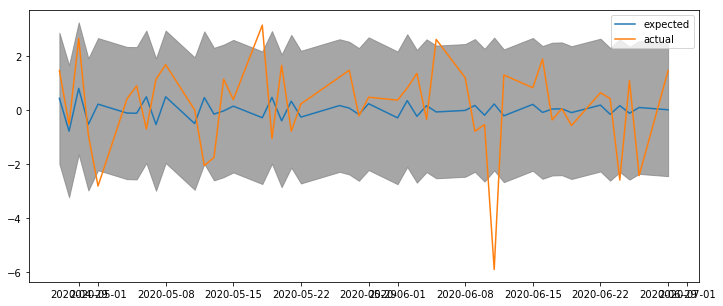

In [210]:
plt.figure(figsize=(12, 5))
return_expected = pd.DataFrame(forecasted, index=hist_testing.index)
return_lb = pd.DataFrame(forecasted_bounds[:, 0], index=hist_testing.index)
return_ub = pd.DataFrame(forecasted_bounds[:, 1], index=hist_testing.index)
plt.plot(return_expected, label='expected')
plt.plot(hist_testing, label='actual')
plt.fill_between(hist_testing.index, return_lb.values.reshape([-1]), return_ub.values.reshape([-1]), color='gray', alpha=0.7)
plt.legend()
plt.show()

### GARCH
[DOC](https://arch.readthedocs.io/en/latest/)
#### Step One: Identify Lag Orders

In [212]:
from arch import arch_model
dict_aic = {}

for l in range(5):
    for p in range(1, 5):
        for q in range(1, 5):
            try:
                split_date = hist_ret.index[-45]
                model = arch_model(hist_ret, mean='ARX', lags=l, vol='Garch', p=p, o=0, q=q, dist='Normal')
                res = model.fit(last_obs=split_date)
                dict_aic[(l, p, q)] = res.aic
            except:
                pass

df_aic = pd.DataFrame.from_dict(dict_aic, orient='index', columns=['aic'])
l, p, q = df_aic[df_aic.aic == df_aic.aic.min()].index[0]
print(f'ARIMA-GARCH order is ({l}, {p}, {q})')

Iteration:      1,   Func. Count:      6,   Neg. LLF: 7028.2674998207385
Iteration:      2,   Func. Count:     16,   Neg. LLF: 7022.5198471929725
Iteration:      3,   Func. Count:     24,   Neg. LLF: 7008.34513253618
Iteration:      4,   Func. Count:     32,   Neg. LLF: 7002.500141507147
Iteration:      5,   Func. Count:     39,   Neg. LLF: 6997.841303669268
Iteration:      6,   Func. Count:     46,   Neg. LLF: 6995.577409303411
Iteration:      7,   Func. Count:     53,   Neg. LLF: 6994.049716541635
Iteration:      8,   Func. Count:     60,   Neg. LLF: 6993.0134858488545
Iteration:      9,   Func. Count:     66,   Neg. LLF: 6992.4521203487575
Iteration:     10,   Func. Count:     72,   Neg. LLF: 6992.120908580768
Iteration:     11,   Func. Count:     78,   Neg. LLF: 6992.114314172518
Iteration:     12,   Func. Count:     84,   Neg. LLF: 6992.114262710973
Iteration:     13,   Func. Count:     90,   Neg. LLF: 6992.114261685545
Optimization terminated successfully.    (Exit mode 0)
      

Iteration:     14,   Func. Count:    144,   Neg. LLF: 6985.63215258419
Iteration:     15,   Func. Count:    153,   Neg. LLF: 6985.592793806407
Iteration:     16,   Func. Count:    162,   Neg. LLF: 6985.58958076363
Iteration:     17,   Func. Count:    171,   Neg. LLF: 6985.589193108672
Iteration:     18,   Func. Count:    180,   Neg. LLF: 6985.589129767547
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6985.589129663129
            Iterations: 18
            Function evaluations: 180
            Gradient evaluations: 18
Iteration:      1,   Func. Count:     10,   Neg. LLF: 7009.687721852299
Iteration:      2,   Func. Count:     24,   Neg. LLF: 7004.552001818611
Iteration:      3,   Func. Count:     36,   Neg. LLF: 7003.800262399716
Iteration:      4,   Func. Count:     47,   Neg. LLF: 6999.422819198044
Iteration:      5,   Func. Count:     59,   Neg. LLF: 6998.60366668698
Iteration:      6,   Func. Count:     71,   Neg. LLF: 6998.251015008538


Iteration:      9,   Func. Count:    110,   Neg. LLF: 6986.218335575198
Iteration:     10,   Func. Count:    121,   Neg. LLF: 6985.557363143178
Iteration:     11,   Func. Count:    132,   Neg. LLF: 6985.3152360684835
Iteration:     12,   Func. Count:    143,   Neg. LLF: 6985.272766160768
Iteration:     13,   Func. Count:    155,   Neg. LLF: 6985.270452336887
Iteration:     14,   Func. Count:    166,   Neg. LLF: 6985.189143319068
Iteration:     15,   Func. Count:    176,   Neg. LLF: 6985.169810203523
Iteration:     16,   Func. Count:    186,   Neg. LLF: 6985.1573747395705
Iteration:     17,   Func. Count:    196,   Neg. LLF: 6985.156211170655
Iteration:     18,   Func. Count:    206,   Neg. LLF: 6985.155738678704
Iteration:     19,   Func. Count:    216,   Neg. LLF: 6985.155736766215
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6985.155736766951
            Iterations: 19
            Function evaluations: 216
            Gradient evaluations

Iteration:      3,   Func. Count:     40,   Neg. LLF: 7031.456717317461
Iteration:      4,   Func. Count:     51,   Neg. LLF: 7022.239093496093
Iteration:      5,   Func. Count:     63,   Neg. LLF: 7019.647988613007
Iteration:      6,   Func. Count:     75,   Neg. LLF: 7019.069881932509
Iteration:      7,   Func. Count:     85,   Neg. LLF: 6986.762866784837
Iteration:      8,   Func. Count:     97,   Neg. LLF: 6985.217178318277
Iteration:      9,   Func. Count:    109,   Neg. LLF: 6982.309245567068
Iteration:     10,   Func. Count:    119,   Neg. LLF: 6980.132552907024
Iteration:     11,   Func. Count:    129,   Neg. LLF: 6979.783617692865
Iteration:     12,   Func. Count:    139,   Neg. LLF: 6979.750303592797
Iteration:     13,   Func. Count:    149,   Neg. LLF: 6979.749795001517
Iteration:     14,   Func. Count:    159,   Neg. LLF: 6979.749791870983
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6979.749791150069
            Iterations: 14


Iteration:      5,   Func. Count:     67,   Neg. LLF: 6979.648743063283
Iteration:      6,   Func. Count:     80,   Neg. LLF: 6978.178773132326
Iteration:      7,   Func. Count:     93,   Neg. LLF: 6976.905149608432
Iteration:      8,   Func. Count:    105,   Neg. LLF: 6976.099631392071
Iteration:      9,   Func. Count:    117,   Neg. LLF: 6975.439492498655
Iteration:     10,   Func. Count:    129,   Neg. LLF: 6973.687498943613
Iteration:     11,   Func. Count:    141,   Neg. LLF: 6973.502305483108
Iteration:     12,   Func. Count:    153,   Neg. LLF: 6972.999780816497
Iteration:     13,   Func. Count:    165,   Neg. LLF: 6972.629187486447
Iteration:     14,   Func. Count:    177,   Neg. LLF: 6972.493944105072
Iteration:     15,   Func. Count:    189,   Neg. LLF: 6972.415785848931
Iteration:     16,   Func. Count:    201,   Neg. LLF: 6972.369320749978
Iteration:     17,   Func. Count:    213,   Neg. LLF: 6972.352959809682
Iteration:     18,   Func. Count:    225,   Neg. LLF: 6972.35143

Iteration:      1,   Func. Count:     13,   Neg. LLF: 7016.567499054664
Iteration:      2,   Func. Count:     31,   Neg. LLF: 7003.818329799586
Iteration:      3,   Func. Count:     48,   Neg. LLF: 7002.9250905734025
Iteration:      4,   Func. Count:     62,   Neg. LLF: 6991.704596455285
Iteration:      5,   Func. Count:     76,   Neg. LLF: 6985.002394018318
Iteration:      6,   Func. Count:     90,   Neg. LLF: 6982.760437755459
Iteration:      7,   Func. Count:    105,   Neg. LLF: 6980.289608376364
Iteration:      8,   Func. Count:    120,   Neg. LLF: 6978.821656035128
Iteration:      9,   Func. Count:    135,   Neg. LLF: 6976.84631388681
Iteration:     10,   Func. Count:    150,   Neg. LLF: 6975.30053548118
Iteration:     11,   Func. Count:    164,   Neg. LLF: 6972.957430940431
Iteration:     12,   Func. Count:    178,   Neg. LLF: 6972.378936826137
Iteration:     13,   Func. Count:    192,   Neg. LLF: 6972.200628203879
Iteration:     14,   Func. Count:    206,   Neg. LLF: 6972.122678

Iteration:      6,   Func. Count:     78,   Neg. LLF: 6970.3477473202865
Iteration:      7,   Func. Count:     91,   Neg. LLF: 6970.323635619576
Iteration:      8,   Func. Count:    102,   Neg. LLF: 6969.584577193706
Iteration:      9,   Func. Count:    113,   Neg. LLF: 6969.514348592921
Iteration:     10,   Func. Count:    124,   Neg. LLF: 6969.435269515045
Iteration:     11,   Func. Count:    135,   Neg. LLF: 6969.389687393401
Iteration:     12,   Func. Count:    146,   Neg. LLF: 6969.360310715052
Iteration:     13,   Func. Count:    156,   Neg. LLF: 6969.360011210269
Iteration:     14,   Func. Count:    166,   Neg. LLF: 6969.359925183373
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6969.359924202393
            Iterations: 14
            Function evaluations: 167
            Gradient evaluations: 14
Iteration:      1,   Func. Count:     11,   Neg. LLF: 6992.4034514016985
Iteration:      2,   Func. Count:     27,   Neg. LLF: 6977.62368105

Iteration:     24,   Func. Count:    321,   Neg. LLF: 6968.897621223361
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6968.897621221826
            Iterations: 24
            Function evaluations: 321
            Gradient evaluations: 24
Iteration:      1,   Func. Count:     13,   Neg. LLF: 7007.984029358291
Iteration:      2,   Func. Count:     31,   Neg. LLF: 6994.681439326898
Iteration:      3,   Func. Count:     48,   Neg. LLF: 6993.728170634849
Iteration:      4,   Func. Count:     64,   Neg. LLF: 6993.001251697987
Iteration:      5,   Func. Count:     79,   Neg. LLF: 6983.847490486878
Iteration:      6,   Func. Count:     94,   Neg. LLF: 6978.569899146449
Iteration:      7,   Func. Count:    109,   Neg. LLF: 6976.07759209558
Iteration:      8,   Func. Count:    124,   Neg. LLF: 6974.208332258755
Iteration:      9,   Func. Count:    138,   Neg. LLF: 6973.31556300374
Iteration:     10,   Func. Count:    152,   Neg. LLF: 6971.751335086907

Iteration:      8,   Func. Count:     91,   Neg. LLF: 6980.386131690616
Iteration:      9,   Func. Count:    103,   Neg. LLF: 6979.908232429101
Iteration:     10,   Func. Count:    113,   Neg. LLF: 6976.038229522143
Iteration:     11,   Func. Count:    124,   Neg. LLF: 6975.349003818485
Iteration:     12,   Func. Count:    134,   Neg. LLF: 6975.135246454002
Iteration:     13,   Func. Count:    143,   Neg. LLF: 6974.637018445734
Iteration:     14,   Func. Count:    152,   Neg. LLF: 6974.576966366916
Iteration:     15,   Func. Count:    161,   Neg. LLF: 6974.576731469658
Iteration:     16,   Func. Count:    170,   Neg. LLF: 6974.576728259687
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6974.576728259912
            Iterations: 16
            Function evaluations: 170
            Gradient evaluations: 16
Iteration:      1,   Func. Count:     10,   Neg. LLF: 7020.456322941359
Iteration:      2,   Func. Count:     26,   Neg. LLF: 7001.7591794524

Iteration:      7,   Func. Count:    103,   Neg. LLF: 6971.325479416537
Iteration:      8,   Func. Count:    118,   Neg. LLF: 6971.058972027617
Iteration:      9,   Func. Count:    131,   Neg. LLF: 6970.609345632371
Iteration:     10,   Func. Count:    144,   Neg. LLF: 6970.212676865002
Iteration:     11,   Func. Count:    157,   Neg. LLF: 6969.149034615385
Iteration:     12,   Func. Count:    170,   Neg. LLF: 6968.699790991899
Iteration:     13,   Func. Count:    183,   Neg. LLF: 6968.452024466795
Iteration:     14,   Func. Count:    195,   Neg. LLF: 6967.868528860766
Iteration:     15,   Func. Count:    207,   Neg. LLF: 6967.6966943167845
Iteration:     16,   Func. Count:    219,   Neg. LLF: 6967.647569111192
Iteration:     17,   Func. Count:    231,   Neg. LLF: 6967.644768492887
Iteration:     18,   Func. Count:    243,   Neg. LLF: 6967.644473035876
Iteration:     19,   Func. Count:    255,   Neg. LLF: 6967.644457578095
Iteration:     20,   Func. Count:    267,   Neg. LLF: 6967.6444

Iteration:      2,   Func. Count:     33,   Neg. LLF: 6993.131445012311
Iteration:      3,   Func. Count:     51,   Neg. LLF: 6992.018280920846
Iteration:      4,   Func. Count:     67,   Neg. LLF: 6991.411323410939
Iteration:      5,   Func. Count:     83,   Neg. LLF: 6986.006959361761
Iteration:      6,   Func. Count:     99,   Neg. LLF: 6979.028223993083
Iteration:      7,   Func. Count:    116,   Neg. LLF: 6975.555542396698
Iteration:      8,   Func. Count:    132,   Neg. LLF: 6973.24396032915
Iteration:      9,   Func. Count:    148,   Neg. LLF: 6972.319444522895
Iteration:     10,   Func. Count:    163,   Neg. LLF: 6971.373679890735
Iteration:     11,   Func. Count:    178,   Neg. LLF: 6970.537338209413
Iteration:     12,   Func. Count:    193,   Neg. LLF: 6968.417312334675
Iteration:     13,   Func. Count:    209,   Neg. LLF: 6968.2402527687955
Iteration:     14,   Func. Count:    224,   Neg. LLF: 6967.795140574775
Iteration:     15,   Func. Count:    239,   Neg. LLF: 6967.52567

Iteration:     23,   Func. Count:    383,   Neg. LLF: 6966.718359663616
Iteration:     24,   Func. Count:    398,   Neg. LLF: 6966.718321766535
Iteration:     25,   Func. Count:    413,   Neg. LLF: 6966.71831999935
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6966.718319999252
            Iterations: 25
            Function evaluations: 413
            Gradient evaluations: 25
Iteration:      1,   Func. Count:     10,   Neg. LLF: 7016.659148870658
Iteration:      2,   Func. Count:     25,   Neg. LLF: 7000.943264958032
Iteration:      3,   Func. Count:     39,   Neg. LLF: 6999.397264403982
Iteration:      4,   Func. Count:     51,   Neg. LLF: 6992.457124170702
Iteration:      5,   Func. Count:     64,   Neg. LLF: 6987.638920297526
Iteration:      6,   Func. Count:     77,   Neg. LLF: 6987.338021231405
Iteration:      7,   Func. Count:     89,   Neg. LLF: 6981.942136396265
Iteration:      8,   Func. Count:    102,   Neg. LLF: 6980.69153584778

Iteration:     16,   Func. Count:    222,   Neg. LLF: 6964.5796603632525
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6964.579660363175
            Iterations: 16
            Function evaluations: 222
            Gradient evaluations: 16
Iteration:      1,   Func. Count:     13,   Neg. LLF: 6989.704901298991
Iteration:      2,   Func. Count:     31,   Neg. LLF: 6973.059674555298
Iteration:      3,   Func. Count:     48,   Neg. LLF: 6971.713676629941
Iteration:      4,   Func. Count:     64,   Neg. LLF: 6971.443022484194
Iteration:      5,   Func. Count:     80,   Neg. LLF: 6970.962147617747
Iteration:      6,   Func. Count:     96,   Neg. LLF: 6970.832222180003
Iteration:      7,   Func. Count:    111,   Neg. LLF: 6968.39491383291
Iteration:      8,   Func. Count:    127,   Neg. LLF: 6968.305299952296
Iteration:      9,   Func. Count:    142,   Neg. LLF: 6968.1995062843525
Iteration:     10,   Func. Count:    156,   Neg. LLF: 6967.554974153

Iteration:     10,   Func. Count:    175,   Neg. LLF: 6969.368456650409
Iteration:     11,   Func. Count:    192,   Neg. LLF: 6968.961670069555
Iteration:     12,   Func. Count:    208,   Neg. LLF: 6966.632746098599
Iteration:     13,   Func. Count:    224,   Neg. LLF: 6966.307434660434
Iteration:     14,   Func. Count:    240,   Neg. LLF: 6965.944640058866
Iteration:     15,   Func. Count:    257,   Neg. LLF: 6965.6249374977215
Iteration:     16,   Func. Count:    273,   Neg. LLF: 6965.195726721692
Iteration:     17,   Func. Count:    289,   Neg. LLF: 6964.969347138916
Iteration:     18,   Func. Count:    305,   Neg. LLF: 6964.338206237546
Iteration:     19,   Func. Count:    321,   Neg. LLF: 6964.25380049602
Iteration:     20,   Func. Count:    336,   Neg. LLF: 6964.201202728324
Iteration:     21,   Func. Count:    351,   Neg. LLF: 6964.166790908714
Iteration:     22,   Func. Count:    366,   Neg. LLF: 6964.140924614301
Iteration:     23,   Func. Count:    381,   Neg. LLF: 6964.13648

#### Step Two: FIt the Model

In [249]:
model = arch_model(hist_ret, mean='ARX', lags=l, vol='Garch', p=p, o=0, q=q, dist='Normal')
res = model.fit(last_obs=split_date)

Iteration:      1,   Func. Count:     12,   Neg. LLF: 6986.216230134513
Iteration:      2,   Func. Count:     30,   Neg. LLF: 6967.382598522084
Iteration:      3,   Func. Count:     46,   Neg. LLF: 6966.0872051264505
Iteration:      4,   Func. Count:     61,   Neg. LLF: 6965.861068143049
Iteration:      5,   Func. Count:     76,   Neg. LLF: 6965.698994319409
Iteration:      6,   Func. Count:     90,   Neg. LLF: 6965.519639016675
Iteration:      7,   Func. Count:    105,   Neg. LLF: 6965.48157850029
Iteration:      8,   Func. Count:    120,   Neg. LLF: 6965.4661886641625
Iteration:      9,   Func. Count:    133,   Neg. LLF: 6964.993759345178
Iteration:     10,   Func. Count:    146,   Neg. LLF: 6964.630764462843
Iteration:     11,   Func. Count:    160,   Neg. LLF: 6964.621968527116
Iteration:     12,   Func. Count:    173,   Neg. LLF: 6964.604932991663
Iteration:     13,   Func. Count:    186,   Neg. LLF: 6964.582450106431
Iteration:     14,   Func. Count:    198,   Neg. LLF: 6964.5798

In [250]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           AR - GARCH Model Results                           
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.009
Mean Model:                        AR   Adj. R-squared:                  0.008
Vol Model:                      GARCH   Log-Likelihood:               -6964.58
Distribution:                  Normal   AIC:                           13949.2
Method:            Maximum Likelihood   BIC:                           14014.5
                                        No. Observations:                 5105
Date:                Mon, Jun 29 2020   Df Residuals:                     5095
Time:                        23:18:37   Df Model:                           10
                                   Mean Model                                  
===============================================================================
                  coef    std err          t      P>|t|        95.0% Conf. Int.
-------------------------------------------------------------------------------
Const           0.0710  1.181e-02      6.011  1.845e-09   [4.785e-02,9.415e-02]
Close[1]       -0.0612  1.452e-02     -4.217  2.480e-05 [-8.969e-02,-3.277e-02]
Close[2]       -0.0307  1.544e-02     -1.991  4.644e-02 [-6.100e-02,-4.853e-04]
Close[3]       -0.0107  1.503e-02     -0.710      0.478  [-4.012e-02,1.878e-02]
Close[4]   -8.4833e-03  1.548e-02     -0.548      0.584  [-3.882e-02,2.185e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0385  1.033e-02      3.730  1.914e-04 [1.828e-02,5.877e-02]
alpha[1]       0.0830  2.592e-02      3.201  1.370e-03   [3.217e-02,  0.134]
alpha[2]       0.1295  3.455e-02      3.750  1.769e-04   [6.183e-02,  0.197]
beta[1]        0.2699      0.424      0.637      0.524     [ -0.561,  1.100]
beta[2]        0.4908      0.378      1.300      0.194     [ -0.249,  1.231]
============================================================================

Covariance estimator: robust
"""

#### Step Three: Evaluate Model via Residuals

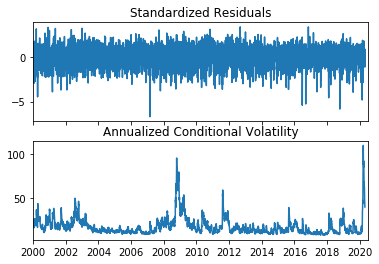

In [231]:
res.plot(annualize='D')
std_resid = res.resid / res.conditional_volatility
std_resid.dropna(inplace=True)

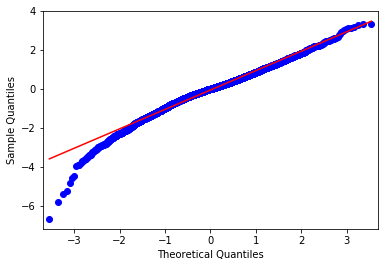

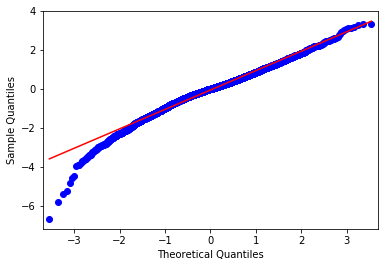

In [238]:
sm.qqplot(std_resid, line='s')

In [240]:
stat, p = normaltest(std_resid)
print(f'Statistics={stat:.3f}, p={p:.3f}')       # H0: Gaussian
stat, p = shapiro(std_resid)
print(f'Statistics={stat:.3f}, p={p:.3f}')       # H0: Gaussian

Statistics=380.445, p=0.000
Statistics=0.982, p=0.000


#### Step Four: Forecast

In [241]:
forecasts = res.forecast(horizon=1, start=split_date)

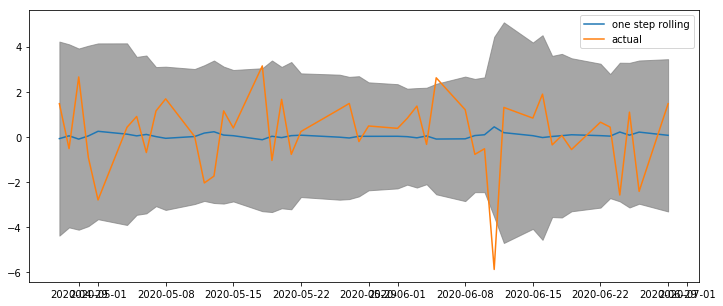

In [245]:
conf = np.sqrt(forecasts.variance[split_date:])*1.96

plt.figure(figsize=(12, 5))
plt.plot(forecasts.mean[split_date:], label='one step rolling')
plt.plot(hist_ret[split_date:], label='actual')
plt.fill_between(hist_ret[split_date:].index, (forecasts.mean[split_date:]-conf).values.reshape(-1), (forecasts.mean[split_date:]+conf).values.reshape(-1), color='gray', alpha=0.7)
plt.legend()
plt.show()